# Beta diversity, Cluster Richness, and Sensory Fraction figures

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets
from sklearn import decomposition
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import plot_confusion_matrix
from pathlib import Path
import os
import matplotlib.pyplot as plt
#import cupy as np
#import gnumpy as gpu
import numpy as np
from catboost import CatBoost
from sklearn import preprocessing
from catboost.utils import eval_metric
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import pickle
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

In [2]:
full_abundance = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/113K_copy_number_abundance.csv')
full_abundance = full_abundance.drop('Unnamed: 0',axis=1)
full_abundance

,0,1,2,3,4,5,6,7,8,9,...,108955,108956,108957,108958,108959,108960,108961,108962,biome,GOLD Analysis Project ID
0,0.000078,0.001290,0.000117,0.000096,0.002859,0.002650,0.000295,0.00076,0.000048,0.000104,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0243760
1,0.000100,0.000420,0.000000,0.000120,0.000000,0.000347,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0245139
2,0.000000,0.003606,0.000000,0.000626,0.005829,0.005152,0.000030,0.00000,0.000040,0.000101,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0244137
3,0.000332,0.007939,0.000000,0.000000,0.002540,0.000000,0.000288,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0245235
4,0.000000,0.001101,0.000000,0.005908,0.006754,0.001515,0.000117,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0243931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16218,0.000000,0.000000,0.000000,0.000000,0.000084,0.000000,0.000000,0.00000,0.000777,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00004,0.000018,0.000000,Environmental:Terrestrial:Agricultural land,Ga0506512
16219,0.000000,0.000000,0.000000,0.002855,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000146,Environmental:Aquatic:River,Ga0501195
16220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Fungi:Unclassified,Ga0503096
16221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Plants:Phylloplane/Leaf,Ga0501119


#### Select only biomes without unclassified as in the final catboost dataset

In [3]:
grouped_df = full_abundance.copy()
# rename the unclassified that we want to keep in the model, not as complex ecosystem
grouped_df.loc[grouped_df.biome == 'Host-associated:Annelida:Unclassified','biome'] = 'Host-associated:Annelida:Digestive tube'
grouped_df.loc[grouped_df.biome == 'Host-associated:Arthropoda: Insects:Unclassified','biome']='Host-associated:Arthropoda: Insects'
grouped_df.loc[grouped_df.biome == 'Engineered:WWTP:Unclassified','biome'] = 'Engineered:WWTP'
grouped_df.loc[grouped_df.biome == 'Engineered:Modeled:Unclassified','biome'] = 'Engineered:Modeled'
grouped_df.loc[grouped_df.biome == 'Host-associated:Porifera:Unclassified','biome']='Host-associated:Porifera'
grouped_df.loc[grouped_df.biome == 'Host-associated:Algae:Unclassified','biome']='Host-associated:Algae'
grouped_df.loc[grouped_df.biome == 'Engineered:Bioreactor:Unclassified','biome']='Engineered:Bioreactor'

print("before dropping: ",grouped_df['biome'].nunique())
# filter out any biomes without many CDS counts
#grouped_df = grouped_df[grouped_df["assembled.CDS.Count"]>50000]

# filter out the biomes not clearly defined
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Aquatic:Lentic']
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Peat']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Glacier']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Boreal forest/Taiga']
print("dropped biomes-\nEnvironmental:Aquatic:Lentic\nEnvironmental:Terrestrial:Peat")

#drop unclassified biomes
dropped = grouped_df[grouped_df["biome"].str.contains("Unclassified")==True]
print(dropped.biome.drop_duplicates())
grouped_df = grouped_df[grouped_df["biome"].str.contains("Unclassified")==False]

#drop biomes < 30 metagenomes
which_less = grouped_df.groupby('biome').filter(lambda x : len(x) < 30)
print(which_less.biome.drop_duplicates())
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 30)

grouped_df = grouped_df.reset_index(drop=True)
print("after dropping: ", grouped_df['biome'].nunique())
grouped_df = grouped_df.drop(['GOLD Analysis Project ID'], axis=1)#, "assembled.CDS.Count", 'biome_specific'], axis=1)


before dropping:  77
dropped biomes-
Environmental:Aquatic:Lentic
Environmental:Terrestrial:Peat
28            Environmental:Terrestrial:Unclassified
30                Environmental:Aquatic:Unclassified
85                Engineered:Wastewater:Unclassified
1332             Host-associated:Plants:Unclassified
1427                  Environmental:Air:Unclassified
1739              Host-associated:Fungi:Unclassified
2201    Engineered:Artificial ecosystem:Unclassified
Name: biome, dtype: object
154                      Engineered:Modeled
4092     Environmental:Terrestrial:Sediment
14744     Environmental:Aquatic:Marine lake
Name: biome, dtype: object
after dropping:  64


# Gamma is the span of unique clusters in a biome, and Alpha is the number of clusters at the metagenome level

In [4]:
pall={'Environmental:Aquatic:Lake': 'g',
      'Engineered:WWTP': 'b','Environmental:Terrestrial:Sand': 'g',
      'Environmental:Terrestrial:Palsa': 'g','Host-associated:Annelida:Digestive tube': 'r',
      'Environmental:Terrestrial:Litterfall': 'g','Environmental:Aquatic:Sediment': 'g',
      'Engineered:Bioreactor:Anaerobic-Aerobic': 'b','Engineered:Built environment:Subway': 'b',
      'Environmental:Aquatic:Creek': 'g','Engineered:Solid waste:Composting': 'b',
      'Environmental:Terrestrial:Botanical garden': 'g','Environmental:Aquatic:Hydrothermal vents': 'g',
      'Engineered:Bioreactor:Aerobic': 'b','Host-associated:Plants:Endosphere': 'r',
      'Environmental:Terrestrial:Vadose zone': 'g','Host-associated:Mammals:Stomach': 'r',
      'Environmental:Terrestrial:Glacier': 'g','Environmental:Terrestrial:Tropical forest': 'g',
      'Environmental:Terrestrial:Riparian zone': 'g','Environmental:Aquatic:Shale gas reservoir': 'g',
      'Environmental:Aquatic:Intertidal zone': 'g','Environmental:Terrestrial:Temperate forest': 'g',
      'Environmental:Aquatic:Wetlands': 'g','Environmental:Terrestrial:Rock core/Sediment': 'g',
      'Environmental:Terrestrial:Grasslands': 'g','Environmental:Terrestrial:Watershed': 'g',
      'Environmental:Aquatic:Oceanic': 'g','Host-associated:Plants:Rhizosphere': 'r',
      'Environmental:Terrestrial:Tundra': 'g','Environmental:Terrestrial:Boreal forest/Taiga': 'g',
      'Environmental:Terrestrial:Floodplain': 'g','Environmental:Aquatic:Epipelagic': 'g',
      'Host-associated:Mammals:Large intestine': 'r','Host-associated:Plants:Phylloplane/Leaf': 'r',
      'Host-associated:Mammals: Human:Skin': 'r','Environmental:Aquatic:Coastal': 'g',
      'Engineered:Built environment:Irrigation canal': 'b','Host-associated:Arthropoda: Insects:Gut': 'r',
      'Environmental:Terrestrial:Agricultural land': 'g','Host-associated:Porifera': 'r',
      'Environmental:Terrestrial:Paddy field/soil': 'g','Host-associated:Mammals: Human:Oral cavity': 'r',
      'Host-associated:Mammals: Human:Vagina': 'r','Environmental:Aquatic:Strait': 'g',
      'Environmental:Terrestrial:Soil crust': 'g','Environmental:Terrestrial:Insects nest': 'g',
      'Host-associated:Mammals: Human:Large intestine': 'r','Environmental:Terrestrial:Oil well': 'g',
      'Engineered:Wastewater:Petrochemical': 'b','Engineered:Bioreactor:Digestate': 'b',
      'Environmental:Aquatic:Hot (42-90C)': 'g','Environmental:Terrestrial:Desert': 'g','Host-associated:Algae': 'r',
      'Environmental:Terrestrial:Wetlands': 'g','Environmental:Aquatic:Groundwater': 'g',
      'Environmental:Aquatic:Hypersaline': 'g','Environmental:Aquatic:Inlet': 'g','Environmental:Aquatic:River': 'g',
      'Host-associated:Mollusca:Gills': 'r','Environmental:Aquatic:Ice': 'g',
      'Environmental:Aquatic:Saline': 'g','Engineered:Wastewater:Mine water': 'b','Engineered:Bioreactor': 'b',}

In [5]:
# Alpha is the number of clusters at the metagenome level
# count the # of clusters for each metagenome
grouped_df['alpha'] = (108963 - (grouped_df == 0).astype(int).sum(axis=1))

In [6]:
counting_clusters = grouped_df.drop(['alpha'],axis=1)
mean = counting_clusters.groupby('biome').sum()

# Gamma is the span of unique clusters in a biome
# count the # of clusters that spans the entire biome
mean['gamma'] = 108963 - (mean == 0).astype(int).sum(axis=1)
mean = mean.reset_index()
mean = mean[['biome', 'gamma']]
mean = mean.sort_values('gamma', ascending=False)
mean = mean.reset_index(drop=True)
mean = mean.reset_index()
mean

,index,biome,gamma
0,0,Host-associated:Plants:Rhizosphere,38484
1,1,Environmental:Aquatic:Lake,37121
2,2,Environmental:Terrestrial:Wetlands,32432
3,3,Environmental:Terrestrial:Agricultural land,28243
4,4,Environmental:Aquatic:Wetlands,27265
...,...,...,...
59,59,Host-associated:Mammals: Human:Skin,818
60,60,Host-associated:Porifera,777
61,61,Host-associated:Mammals: Human:Oral cavity,451
62,62,Host-associated:Mollusca:Gills,73


In [7]:
grouped_df = grouped_df[['alpha', 'biome']]
grouped_df = grouped_df.merge(mean, on='biome', how='left')
grouped_df = grouped_df.sort_values('index')
grouped_df

,alpha,biome,index,gamma
7833,4706,Host-associated:Plants:Rhizosphere,0,38484
9114,1615,Host-associated:Plants:Rhizosphere,0,38484
915,1118,Host-associated:Plants:Rhizosphere,0,38484
12110,2364,Host-associated:Plants:Rhizosphere,0,38484
12112,2654,Host-associated:Plants:Rhizosphere,0,38484
...,...,...,...,...
4332,2,Host-associated:Mammals: Human:Vagina,63,49
4205,1,Host-associated:Mammals: Human:Vagina,63,49
13800,1,Host-associated:Mammals: Human:Vagina,63,49
4076,2,Host-associated:Mammals: Human:Vagina,63,49


In [8]:
grouped_df['beta_diversity_biome'] = grouped_df.alpha / grouped_df.gamma
grouped_df['beta_diversity_global'] = grouped_df.gamma / 108963
grouped_df

,alpha,biome,index,gamma,beta_diversity_biome,beta_diversity_global
7833,4706,Host-associated:Plants:Rhizosphere,0,38484,0.122285,0.353184
9114,1615,Host-associated:Plants:Rhizosphere,0,38484,0.041965,0.353184
915,1118,Host-associated:Plants:Rhizosphere,0,38484,0.029051,0.353184
12110,2364,Host-associated:Plants:Rhizosphere,0,38484,0.061428,0.353184
12112,2654,Host-associated:Plants:Rhizosphere,0,38484,0.068964,0.353184
...,...,...,...,...,...,...
4332,2,Host-associated:Mammals: Human:Vagina,63,49,0.040816,0.000450
4205,1,Host-associated:Mammals: Human:Vagina,63,49,0.020408,0.000450
13800,1,Host-associated:Mammals: Human:Vagina,63,49,0.020408,0.000450
4076,2,Host-associated:Mammals: Human:Vagina,63,49,0.040816,0.000450


In [9]:
just_beta = grouped_df[['beta_diversity_biome','biome']]
just_beta = just_beta.groupby('biome').mean()
just_beta['stdev'] = grouped_df[['beta_diversity_biome','biome']].groupby('biome').std()
just_beta = just_beta.reset_index()
just_beta.columns = ['biome', 'av_beta_diversity_biome', 'stdev_biome']
grouped_df = grouped_df.merge(just_beta, on='biome', how='left')
grouped_df

,alpha,biome,index,gamma,beta_diversity_biome,beta_diversity_global,av_beta_diversity_biome,stdev_biome
0,4706,Host-associated:Plants:Rhizosphere,0,38484,0.122285,0.353184,0.038608,0.031442
1,1615,Host-associated:Plants:Rhizosphere,0,38484,0.041965,0.353184,0.038608,0.031442
2,1118,Host-associated:Plants:Rhizosphere,0,38484,0.029051,0.353184,0.038608,0.031442
3,2364,Host-associated:Plants:Rhizosphere,0,38484,0.061428,0.353184,0.038608,0.031442
4,2654,Host-associated:Plants:Rhizosphere,0,38484,0.068964,0.353184,0.038608,0.031442
...,...,...,...,...,...,...,...,...
14336,2,Host-associated:Mammals: Human:Vagina,63,49,0.040816,0.000450,0.056772,0.107179
14337,1,Host-associated:Mammals: Human:Vagina,63,49,0.020408,0.000450,0.056772,0.107179
14338,1,Host-associated:Mammals: Human:Vagina,63,49,0.020408,0.000450,0.056772,0.107179
14339,2,Host-associated:Mammals: Human:Vagina,63,49,0.040816,0.000450,0.056772,0.107179


In [10]:
grouped_df['type'] = grouped_df['biome'].str.split(':').str[0]

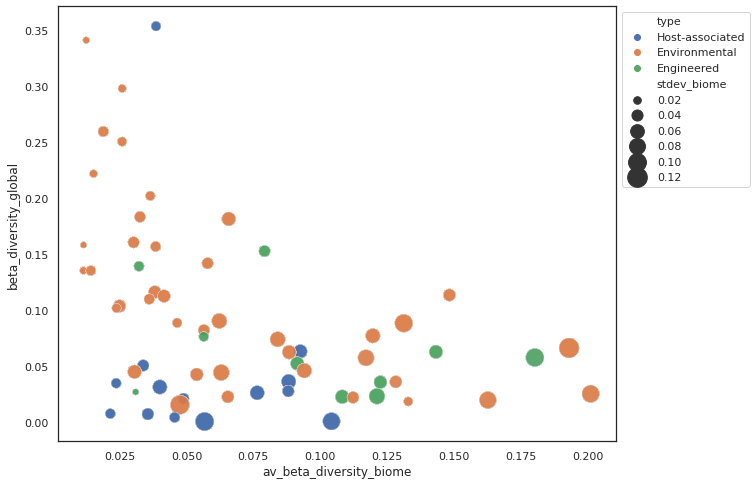

In [16]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("white")
ax = sns.scatterplot(
    data=grouped_df, x="av_beta_diversity_biome", y="beta_diversity_global", hue='type', 
    size="stdev_biome", alpha=0.08,
    sizes=(40, 400) #hue_norm=(0, 7),#
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

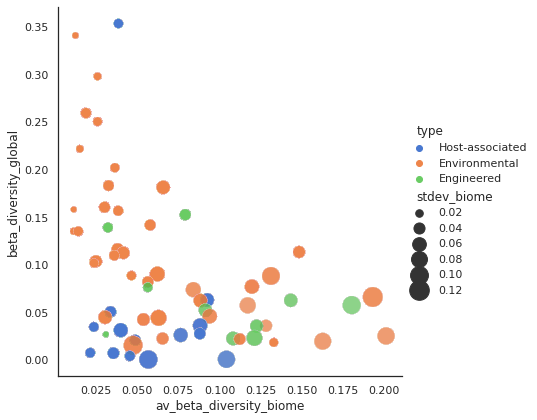

In [19]:
sns.relplot(x="av_beta_diversity_biome", y="beta_diversity_global", hue="type", 
            size="stdev_biome",
            sizes=(40, 400), alpha=.04, palette="muted",
            height=6, data=grouped_df, )

<AxesSubplot:xlabel='biome', ylabel='beta_diversity_global'>

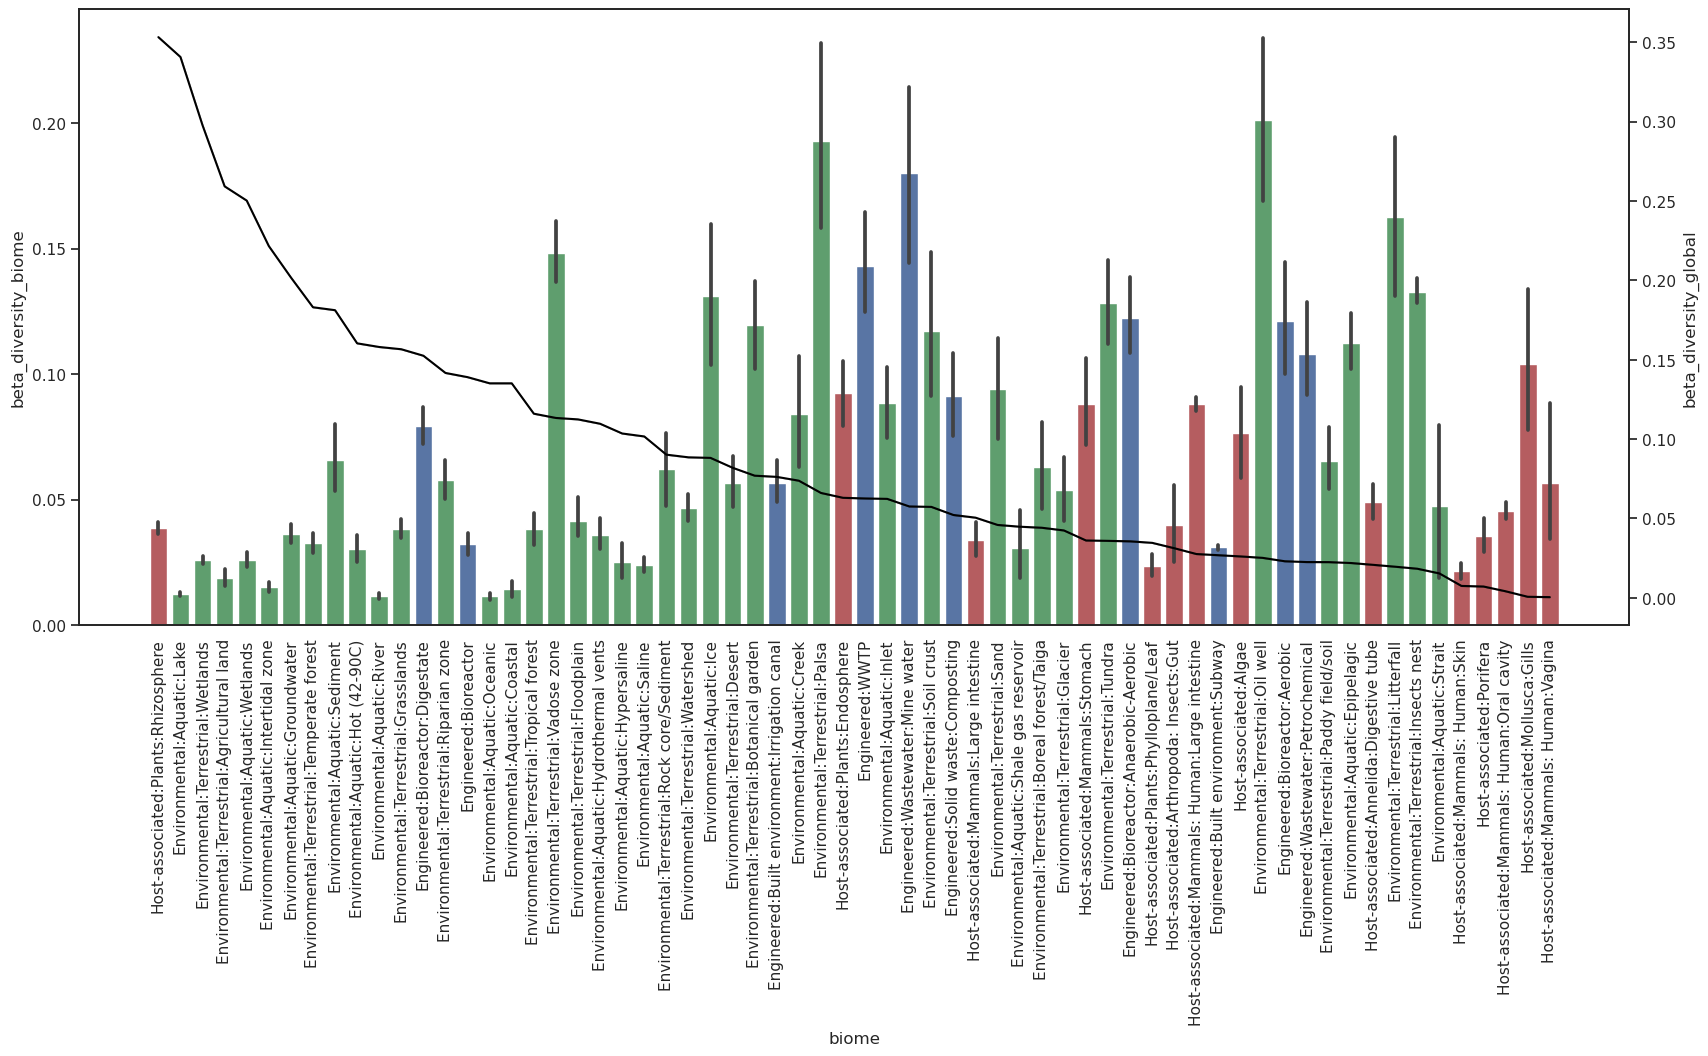

In [18]:
#matplotlib.rc_file_defaults()

ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(20,8))

#sns.set(rc={'figure.figsize':(21.7,8.27)})
sns.set_style("white")
plt.xticks(rotation=90)
#sns.barplot(
 #   data=grouped_df,x="biome", y="total_count", palette=pall)

sns.barplot(data = grouped_df, x='biome', y='beta_diversity_biome', ax=ax1, palette=pall)
ax2 = ax1.twinx()
sns.lineplot(data = grouped_df, x='biome', y='beta_diversity_global', sort = False, ax=ax2, color='black')


<AxesSubplot:xlabel='biome', ylabel='beta_diversity_global'>

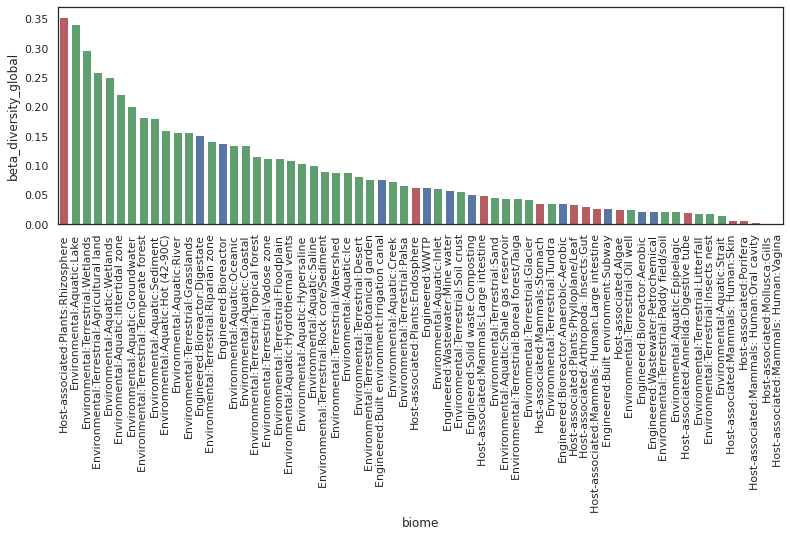

In [22]:
#matplotlib.rc_file_defaults()

ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(13,4))

#sns.set(rc={'figure.figsize':(21.7,8.27)})
sns.set_style("white")
plt.xticks(rotation=90)
#sns.barplot(
 #   data=grouped_df,x="biome", y="total_count", palette=pall)

sns.barplot(data = grouped_df, x='biome', y='beta_diversity_global', ax=ax1, palette=pall) #7525 #7434 #7183, #7052 #6946 #6639


# Sensory fraction, fraction of all proteins that are HK sensors

#### Make another copy of grouped_df to override above code

In [20]:
grouped_df['sum_abundance'] = grouped_df.drop(['biome'], axis=1).sum(axis=1)

In [ ]:
g['stdev'] = grouped_df.drop(['biome', 'sum_abundance'], axis=1).std(axis=1)

In [21]:
g_average = grouped_df[['biome', 'sum_abundance']]#, 'stdev']]
g_average = g_average.groupby('biome').mean()
g_average = g_average.reset_index()
g_average = g_average.sort_values('sum_abundance', ascending=False)
g_average = g_average.reset_index(drop=True)
g_average = g_average.reset_index(drop=False)
g_average

,index,biome,sum_abundance
0,0,Host-associated:Mammals: Human:Large intestine,0.540631
1,1,Environmental:Terrestrial:Soil crust,0.427490
2,2,Engineered:Wastewater:Petrochemical,0.408078
3,3,Engineered:Bioreactor:Digestate,0.374869
4,4,Environmental:Terrestrial:Insects nest,0.363644
...,...,...,...
59,59,Environmental:Terrestrial:Agricultural land,0.051859
60,60,Host-associated:Mammals: Human:Vagina,0.042268
61,61,Environmental:Terrestrial:Paddy field/soil,0.040461
62,62,Host-associated:Mammals: Human:Oral cavity,0.039851


In [22]:
grouped_df = grouped_df.merge(g_average[['index','biome']], on='biome',how='left')
grouped_df

,0,1,2,3,4,5,6,7,8,9,...,108956,108957,108958,108959,108960,108961,108962,biome,sum_abundance,index
0,0.000078,0.001290,0.000117,0.000096,0.002859,0.002650,0.000295,0.00076,0.000048,0.000104,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,0.325569,0
1,0.000100,0.000420,0.000000,0.000120,0.000000,0.000347,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,0.309660,0
2,0.000000,0.003606,0.000000,0.000626,0.005829,0.005152,0.000030,0.00000,0.000040,0.000101,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,0.738792,0
3,0.000332,0.007939,0.000000,0.000000,0.002540,0.000000,0.000288,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,0.207260,0
4,0.000000,0.001101,0.000000,0.005908,0.006754,0.001515,0.000117,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,1.095002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000193,0.000000,...,0.00002,0.000044,0.000034,0.000041,0.00000,0.000000,0.000000,Environmental:Terrestrial:Litterfall,0.226000,29
14337,0.000000,0.000000,0.000000,0.000000,0.000084,0.000000,0.000000,0.00000,0.000777,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00004,0.000018,0.000000,Environmental:Terrestrial:Agricultural land,0.345251,59
14338,0.000000,0.000000,0.000000,0.002855,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000146,Environmental:Aquatic:River,0.149111,54
14339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Host-associated:Plants:Phylloplane/Leaf,0.026661,49


In [23]:
grouped_df = grouped_df.sort_values('index', ascending=True)

<AxesSubplot:xlabel='biome', ylabel='sum_abundance'>

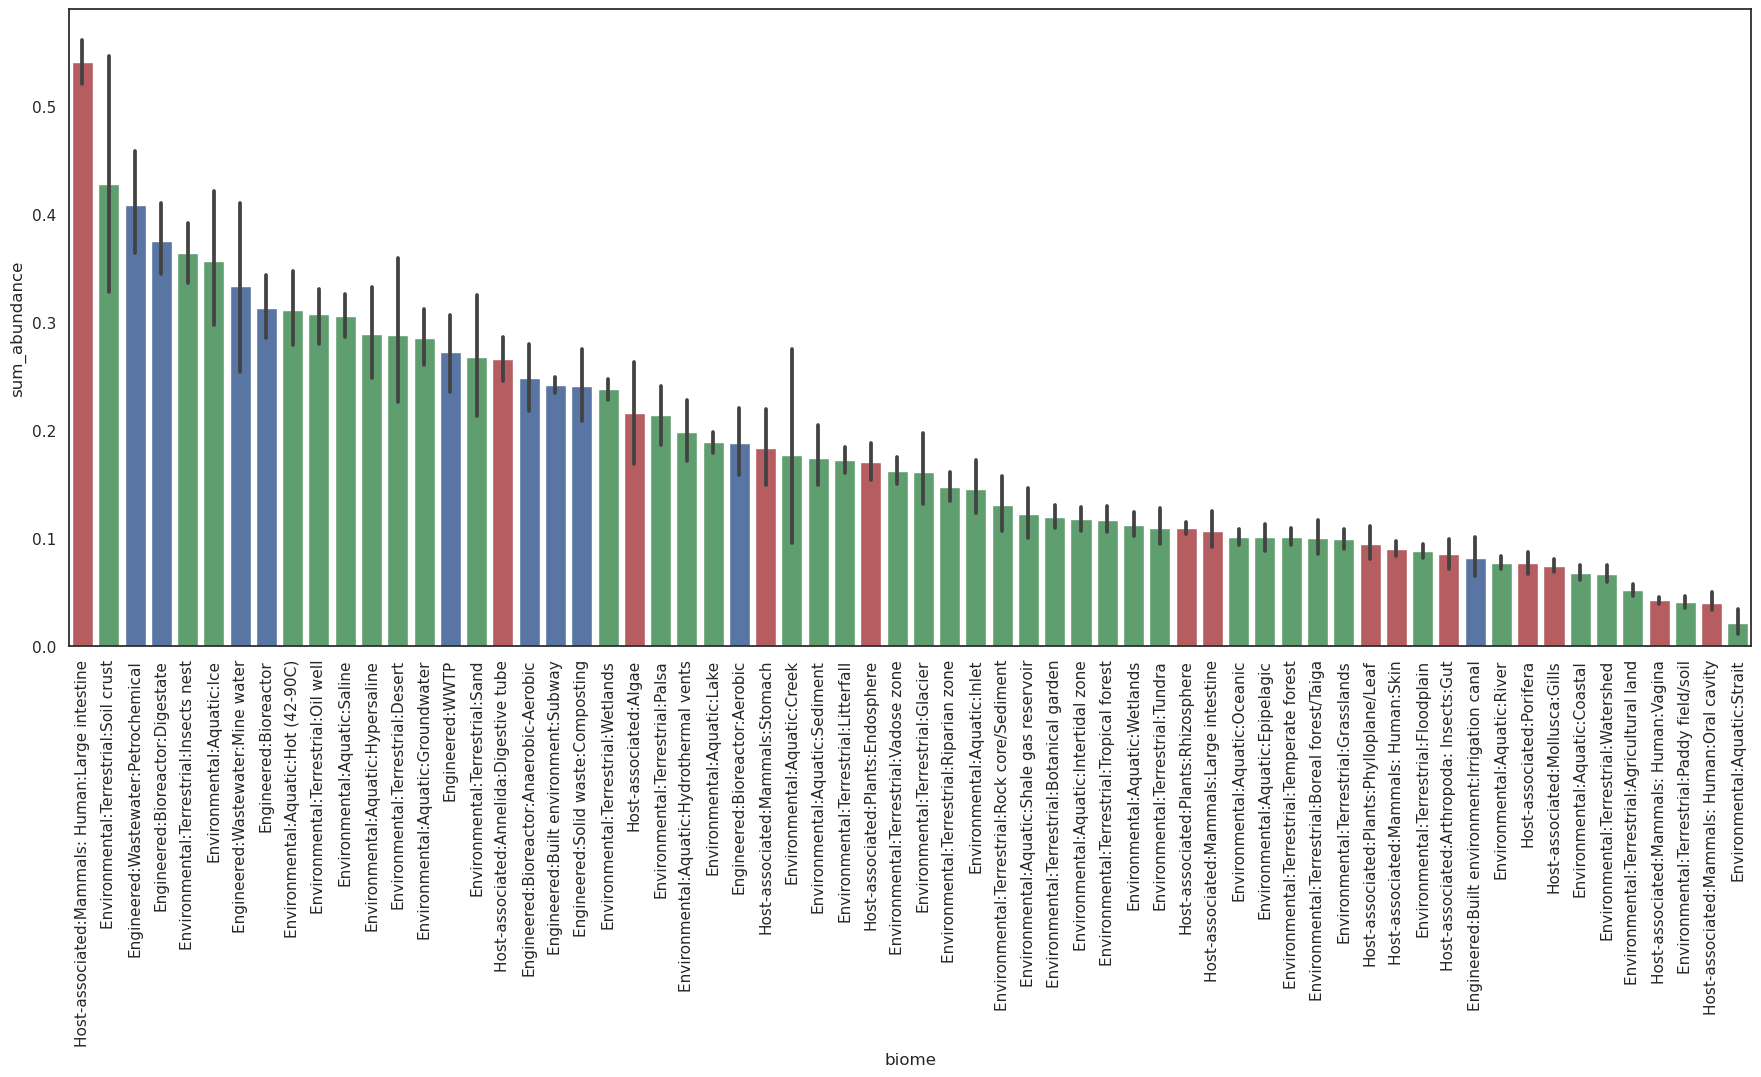

In [24]:
sns.set(rc={'figure.figsize':(21.7,8.27)})
sns.set_style("white")
plt.xticks(rotation=90)
sns.barplot(
    data=grouped_df,x="biome", y="sum_abundance", palette=pall)

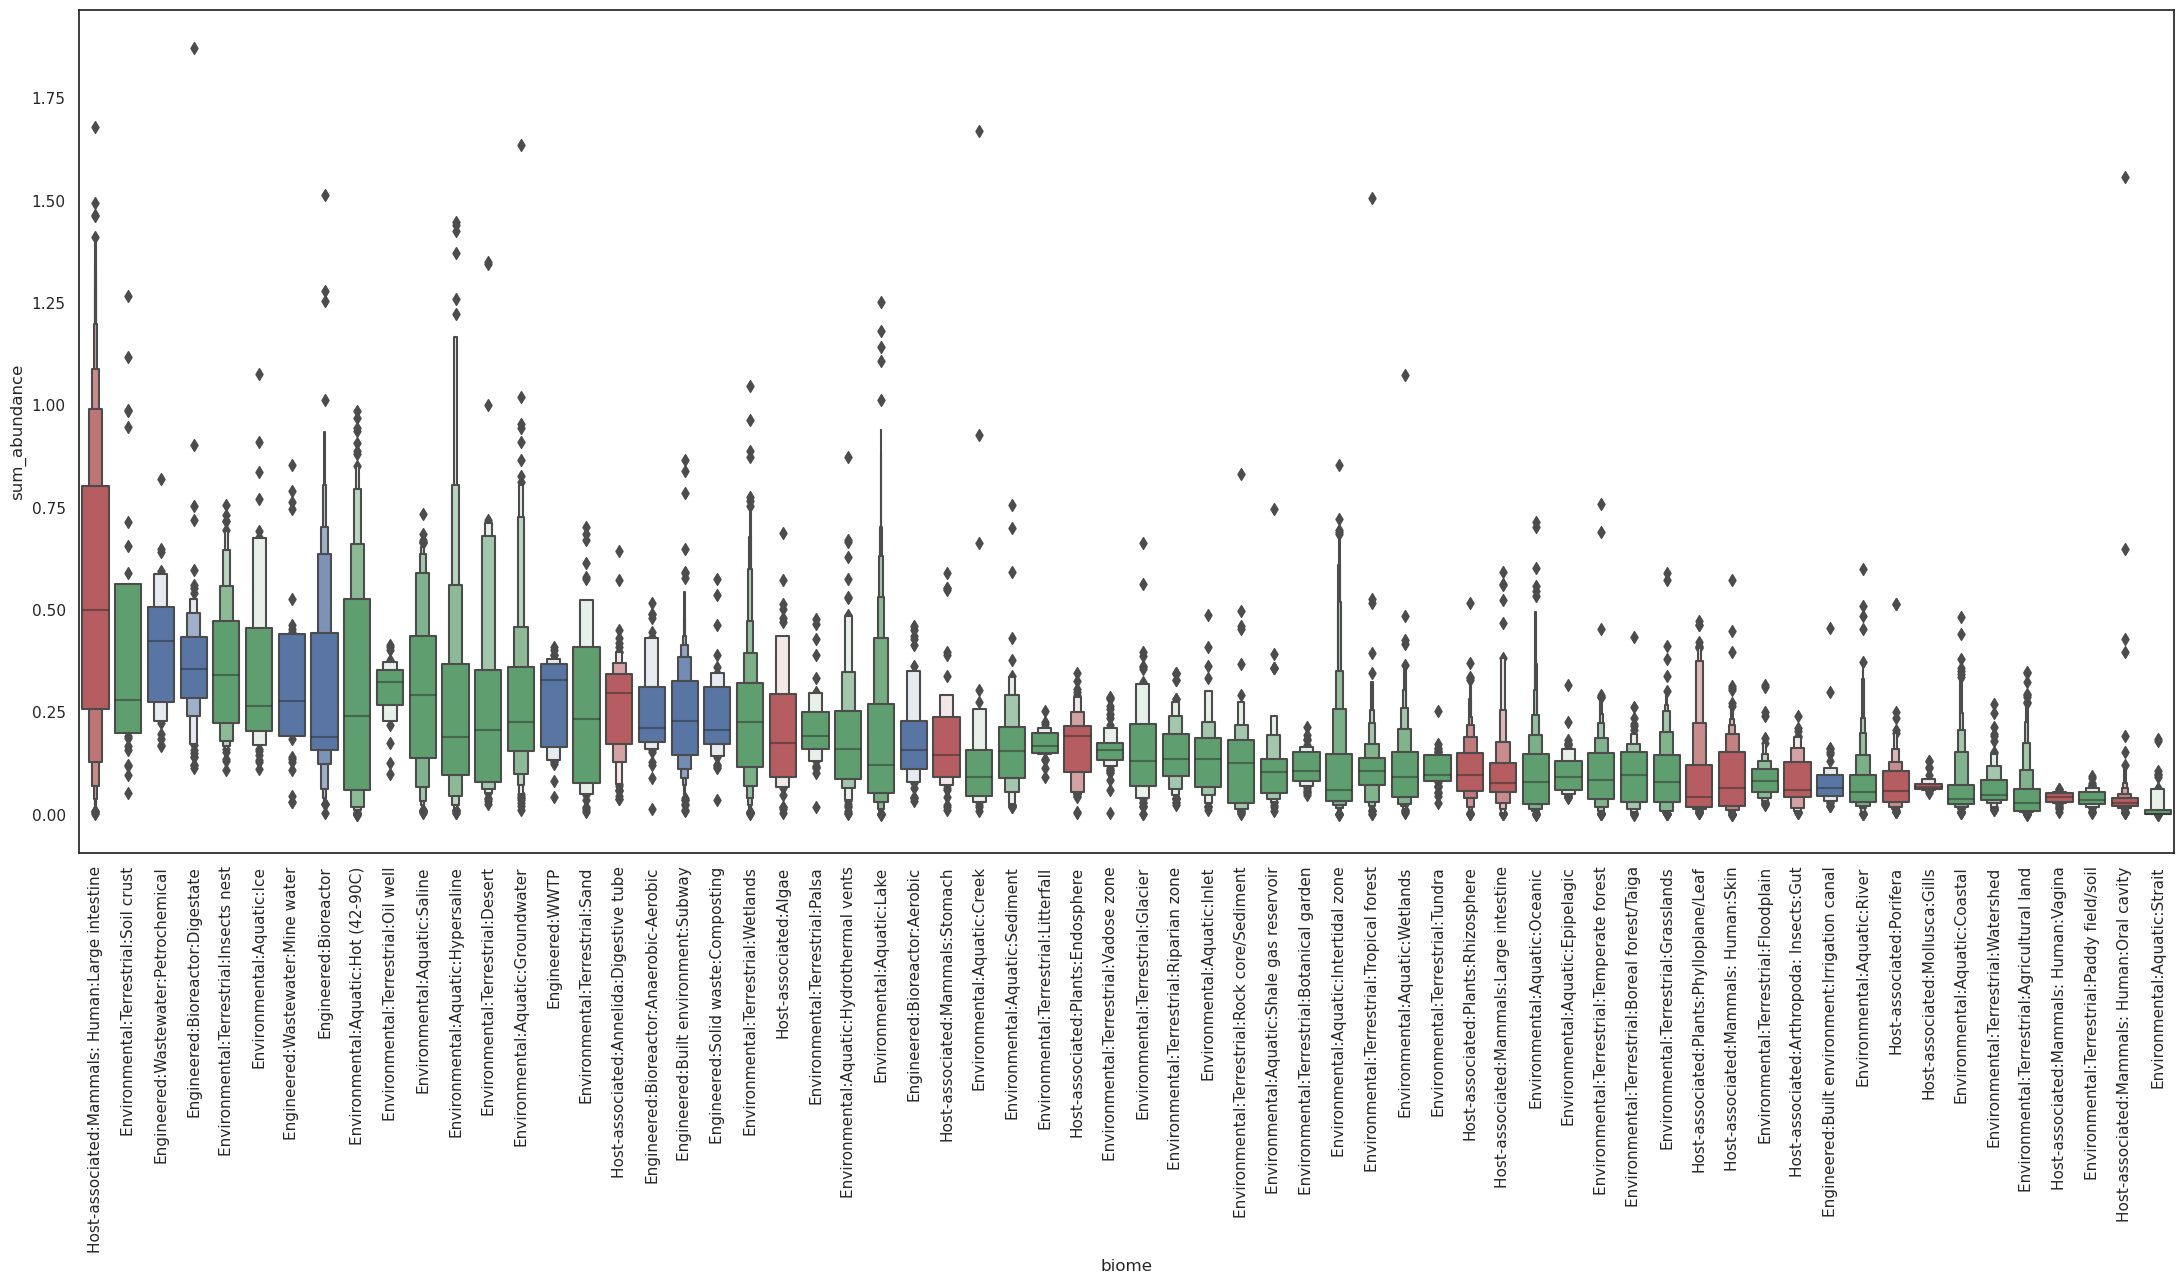

In [25]:
sns.set(rc={'figure.figsize':(22,13)})
sns.set_style("white")

plt.xticks(rotation=90)
sns.boxenplot(data=grouped_df, x="biome", y="sum_abundance", palette=pall)

plt.tight_layout()
plt.show()